In [1]:
import pandas as pd

df = pd.read_csv("final_retail_sales_dataset.csv")

df.head()
df.shape


(30000, 12)

In [2]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order ID             30000 non-null  int64  
 1   Gender               30000 non-null  object 
 2   Age                  30000 non-null  int64  
 3   Quantity             30000 non-null  int64  
 4   Category             30000 non-null  object 
 5   Channel              30000 non-null  object 
 6   Shipping city state  30000 non-null  object 
 7   Status               30000 non-null  object 
 8   Size                 30000 non-null  object 
 9   Date                 30000 non-null  object 
 10  Month                30000 non-null  object 
 11  Amount               30000 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


Order ID               0
Gender                 0
Age                    0
Quantity               0
Category               0
Channel                0
Shipping city state    0
Status                 0
Size                   0
Date                   0
Month                  0
Amount                 0
dtype: int64

In [3]:
X = df.drop(columns=["Amount", "Order ID", "Date"])
y = df["Amount"]


In [4]:
categorical_features = [
    "Gender",
    "Category",
    "Channel",
    "Shipping city state",
    "Status",
    "Size",
    "Month"
]

numerical_features = ["Age", "Quantity"]


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Quantity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Category',
                                                   'Channel',
                                                   'Shipping city state',
                                                   'Status', 'Size',
                                                   'Month'])])),
                ('model', LinearRegression())])

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr_pred = lr_pipeline.predict(X_test)

print("Linear Regression Results")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("R2 Score:", r2_score(y_test, lr_pred))


Linear Regression Results
RMSE: 71.19869082820571
R2 Score: 0.9403815675747298


In [9]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Quantity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Category',
                                                   'Channel',
                                                   'Shipping city state',
                                                   'Status', 'Size',
                                                   'Month'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [10]:
rf_pred = rf_pipeline.predict(X_test)

print("Random Forest Results")
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("R2 Score:", r2_score(y_test, rf_pred))


Random Forest Results
RMSE: 77.6233606615741
R2 Score: 0.9291366924352473


In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=5,
    scoring="r2"
)

print("Cross Validation R2 Scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())


Cross Validation R2 Scores: [0.93161372 0.9316748  0.92977982 0.92712585 0.92802757]
Mean CV R2: 0.9296443512629071


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [150, 250],
    "model__max_depth": [None, 15, 25]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)


Best Parameters: {'model__max_depth': 15, 'model__n_estimators': 250}
Best CV R2: 0.934071296940631


In [13]:
best_model = grid_search.best_estimator_

final_pred = best_model.predict(X_test)

print("Final Model Results")
print("RMSE:", np.sqrt(mean_squared_error(y_test, final_pred)))
print("R2 Score:", r2_score(y_test, final_pred))


Final Model Results
RMSE: 74.53188264412022
R2 Score: 0.9346687873422238


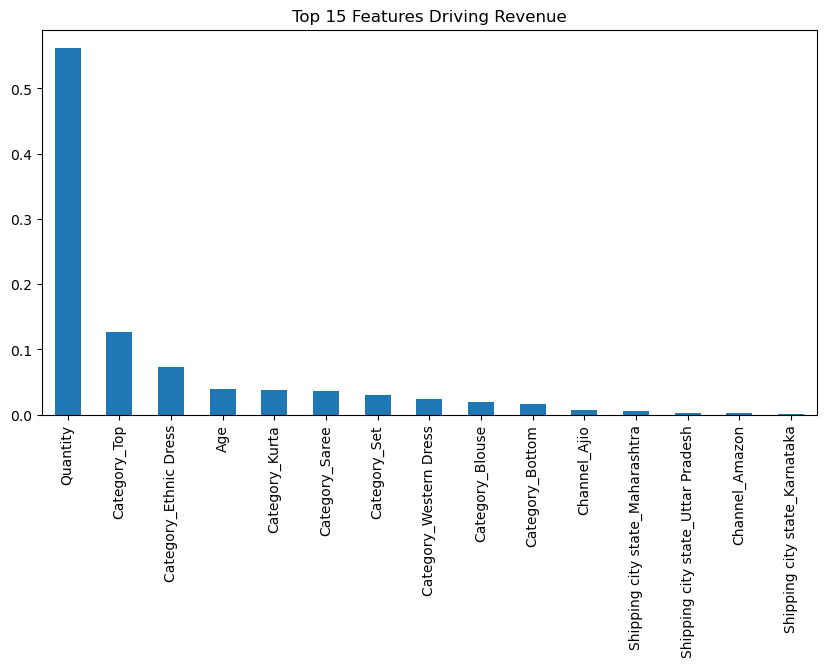

In [14]:
import matplotlib.pyplot as plt

ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"]
encoded_features = ohe.get_feature_names_out(categorical_features)

all_features = numerical_features + list(encoded_features)

importances = best_model.named_steps["model"].feature_importances_

feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feature_importance.head(15).plot(kind="bar")
plt.title("Top 15 Features Driving Revenue")
plt.show()
